# Search Engine

In [1]:
%load_ext autoreload
%autoreload 2

In [38]:
import time
import os
def time_elapsed(s):
    '''
    Function to establish baselines for time needed to setup a search engine
    '''
    print("Time Elapsed: {} seconds".format(round(time.time() - s, 4)))

## Importing embedding nets

In [39]:
import pickle

In [51]:
s = time.time()
text_net = pickle.load(open("pickles/models/entire_nuswide_model.p", "rb"))
def get_text_embedding(*data):
    return text_net.text_embedding_net.to('cuda')(data[0])
text_net.get_embedding = get_text_embedding

image_net = pickle.load(open("pickles/models/entire_nuswide_model.p", "rb"))
time_elapsed(s)

Time Elapsed: 0.132 seconds


## Importing datasets

`modality_data[i]` should return `(tensor, index)` of ith item

`modality_from_idx[i]` should return `value` of ith item

#### Image Dataset (NUS-WIDE)

In [5]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

In [6]:
s = time.time()

image_directory = 'data/Flickr'
image_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

image_data = ImageFolder('data/Flickr', transform = image_transform)
image_from_idx = ImageFolder('data/Flickr', transform = None)

time_elapsed(s)

Time Elapsed: 2.1633 seconds


#### Text Dataset (word2vec)

In [7]:
s = time.time()

word2vec_dict = pickle.load(open("pickles/word_embeddings/word_embeddings_tensors.p", "rb"))
print(len(word2vec_dict))

time_elapsed(s)

999994
Time Elapsed: 65.6275 seconds


In [41]:
s = time.time()

text_from_idx = [None] * len(word2vec_dict)
text_data = [None] * len(word2vec_dict)
for idx, (key, value) in enumerate(word2vec_dict.items()):
    text_from_idx[idx] = key
    text_data[idx] = (value, idx)

time_elapsed(s)

Time Elapsed: 1.6741 seconds


## Creating Data Loaders

Need to enable batch processing of data for GPU acceleration

In [42]:
from torch.cuda import is_available

batch_size = 128
cuda = is_available()
kwargs = {'num_workers': 4, 'pin_memory': True} if cuda else {}

In [62]:
from torch.utils.data import DataLoader

image_dataloader = DataLoader(image_data, batch_size = batch_size, **kwargs)
text_dataloader = DataLoader(text_data, batch_size = batch_size, **kwargs)

## Setting up SearchEngines

In [76]:
from search import SearchEngine

In [77]:
embedding_dimension = 30 # embedding dimension of network being used 
save_directory = './binary_embeddings'

In [78]:
text_search_engine = SearchEngine(
    data = text_dataloader,
    threshold = 0,
    embedding_net = text_net,
    embedding_dimension = embedding_dimension,
    cuda = cuda,
    save_directory = save_directory + '/text',
    embeddings_name = "wiki_word2vec"
)

In [79]:
image_search_engine = SearchEngine(
    data = image_dataloader,
    threshold = 0,
    embedding_net = image_net,
    embedding_dimension = embedding_dimension,
    cuda=cuda,
    save_directory = save_directory + '/image',
    embeddings_name = "nuswide")

### Sanity Check

Want to ensure threshold creates binarized vectors with a good mix of ones and zeros

In [80]:
import random

In [107]:
s = time.time()
image = image_from_idx[random.randint(0,len(image_from_idx))][0]
image_tensor = image_transform(image)[None,:,:,:]
embedding = image_search_engine.get_binarized_embedding(image_tensor, threshold = 0)
print(embedding[0])
print("{} ones and {} zeroes".format(sum([bool(i) for i in embedding[0]]), sum(not i for i in embedding[0])))
time_elapsed(s)

[1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0.
 1. 1. 1. 1. 1. 1.]
17 ones and 13 zeroes
Time Elapsed: 0.0149 seconds


In [112]:
s = time.time()
text = 'cat'
text_tensor = word2vec_dict[text]
embedding = text_search_engine.get_binarized_embedding(text_tensor.unsqueeze(0), threshold = 0)
print(embedding[0])
print("{} ones and {} zeroes".format(sum([bool(i) for i in embedding[0]]), sum(not i for i in embedding[0])))
time_elapsed(s)

[0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0.
 1. 0. 1. 1. 1. 1.]
14 ones and 16 zeroes
Time Elapsed: 0.002 seconds


## Indexing data in SearchEngines

In [83]:
# Processed images in ~900 seconds

image_search_engine.fit(
    data = image_dataloader, 
    verbose = True, 
    step_size=1000, 
    load_embeddings=True)

Batch 0 of 2107
Batch 1000 of 2107
Batch 2000 of 2107
Finished building index in 0.6631 seconds.


In [84]:
# Processed word vectors in ~20 seconds

text_search_engine.fit(
    data = text_dataloader, 
    verbose = True, 
    step_size=1500, 
    save_embeddings=True)

Batch 0 of 7813
Batch 1500 of 7813
Batch 3000 of 7813
Batch 4500 of 7813
Batch 6000 of 7813
Batch 7500 of 7813
Finished building index in 20.7001 seconds.


## Sanity Check

Index of each search engine should be the same length as the data

In [ ]:
assert len(image_data) == image_search_engine.index.ntotal
assert len(text_data) == text_search_engine.index.ntotal

## Queries

In [140]:
import matplotlib.pyplot as plt

def target_to_embedding(target, modality):
    if modality == "image":
        tensor = image_transform(target)[None,:,:,:]
        embedding = image_search_engine.get_binarized_embedding(tensor)
    elif modality == "text":
        tensor = word2vec_dict[target]
        embedding = text_net.text_embedding_net.to('cuda')(tensor.to('cuda'))
        embedding = embedding.unsqueeze(0).cpu().detach().numpy()
    else:
        raise Exception("Modality can only be text or image")
    return embedding
    

def query_and_display(target, modality, search_engine, n=5):
    embedding = target_to_embedding(target, modality)
    
    print("TEXT")
    distances, idx = text_search_engine.search(embedding, n=5, verbose = True)
    idx = idx.astype(int)[0]
    for i in range(len(idx)):
        print(i, text_from_idx[idx[i]])
        
        
    print("IMAGE")
    distances, idx = image_search_engine.search(embedding, n=n, verbose = True)
    distances = distances.astype(int)
    results = []
        
    for i in idx.astype(int)[0]:
        results.append(image_from_idx[i])
    
    if modality == "image":
        plt.figure()
        plt.title("Search Query:")
        plt.imshow(target)
    elif modality == "text":
        print("Query = {}".format(target))

    for i in range(len(results)):
        plt.figure()
        plt.title("Search Result {}: Index {}".format(i+1, int(idx[0][i])))
        plt.xlabel("Distance: {}".format(distances[0][i]))
        plt.imshow(results[i][0])
    

TEXT
Median distance: 6.0
Mean distance: 5.599999904632568
Time elapsed: 0.022
0 wind
1 courthouse
2 flag
3 storm
4 building
IMAGE
Median distance: 0.0
Mean distance: 0.4000000059604645
Time elapsed: 0.00618


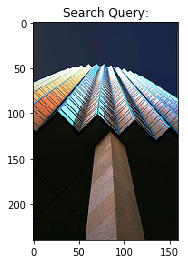

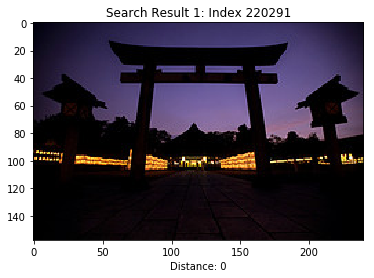

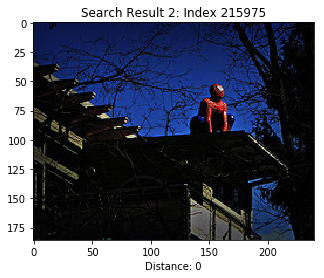

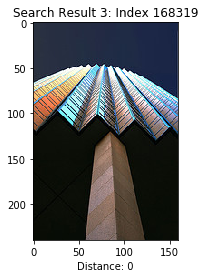

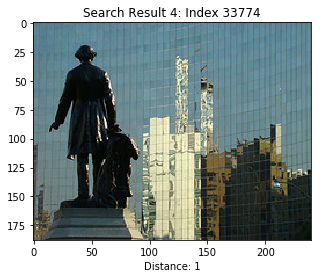

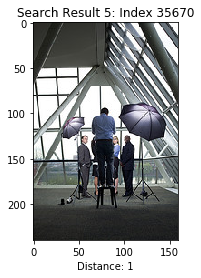

In [141]:
image = image_from_idx[random.randint(0,len(image_from_idx))][0]
image_tensor = image_transform(image)[None,:,:,:]

query_and_display(image, 'image', image_search_engine)

TEXT
Median distance: 8.618826866149902
Mean distance: 8.536970138549805
Time elapsed: 0.02166
0 kayakers
1 kayak
2 yachting
3 surfing
4 lifeguards
IMAGE
Median distance: 4.83170747756958
Mean distance: 4.618575096130371
Time elapsed: 0.00594
Query = beach


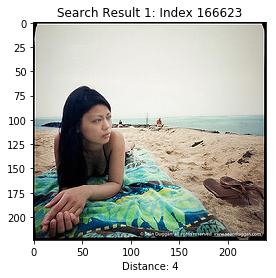

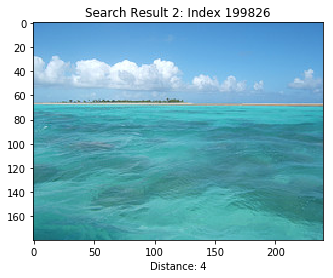

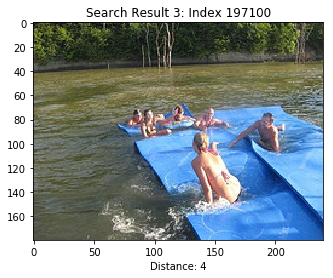

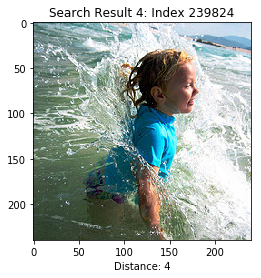

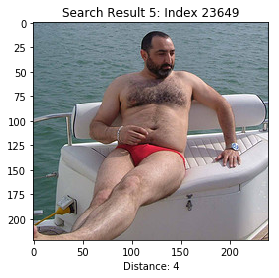

In [143]:
query_and_display('beach', 'text', image_search_engine)

In [127]:
embedding = target_to_embedding(image, "image")
distances, idx = text_search_engine.search(embedding, n=5, verbose = True)

Median distance: 6.0
Mean distance: 5.800000190734863
Time elapsed: 0.02875


In [131]:
for i in idx[0]:
    print(text_from_idx[int(i)])

sun
forest
slope
trail
rain


array([[5115, 3233, 9372, 4586, 3293]])